In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import (OneHotEncoder, MinMaxScaler)
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import mean_squared_error, r2_score

from feature_engine.encoding import (OrdinalEncoder)


# 1) Cargamos y dividimos la data en train y test

In [2]:
data = pd.read_csv('dataset.csv')
data.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,0,11,13,13


In [3]:
xTrain, xTest, yTrain, yTest = train_test_split( data.drop(['G3'], axis=1), data['G3'], test_size=0.15, random_state=2021)
xTrain.shape, yTrain.shape, xTest.shape, yTest.shape

((551, 32), (551,), (98, 32), (98,))

# 2) Analizamos el target

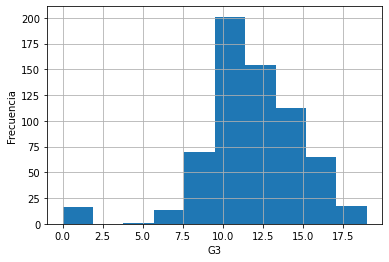

In [4]:
## 2.1) Analisis del target
data['G3'].hist(density=False)
plt.xlabel('G3')
plt.ylabel('Frecuencia')
plt.show()

Tiene una distribución bastante normal (no está tan sesgada), lo podríamos dejar así

# 3)Analizamos los datos faltantes

In [5]:
varsNas = [var for var in xTest.columns if(data[var].isnull().sum() > 0 )]
print(len(varsNas))

0


No tiene faltantes, no hay que realizar imputaciones

# 4) Variables categóricas

## 4.1) Separamos las variables categóricas

In [6]:
categoricalVars = [var for var in xTrain.columns if xTrain[var].dtypes == 'O']
categoricalVars = categoricalVars + ['Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health']

xTrain[categoricalVars] = xTrain[categoricalVars].astype('O')
xTest[categoricalVars] = xTest[categoricalVars].astype('O')
len(categoricalVars)

28

## 4.2) Tratamos las categóricas binarias

In [7]:
# Separamos las categoricas binarias
categoricalBinary = ['school', 'sex', 'address', 'famsize', 'Pstatus', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']


#Vemos las distintas categóricas binarias
for var in categoricalBinary:
    print(var, ' -> ', xTrain[var].unique())

school  ->  ['GP' 'MS']
sex  ->  ['M' 'F']
address  ->  ['U' 'R']
famsize  ->  ['LE3' 'GT3']
Pstatus  ->  ['A' 'T']
schoolsup  ->  ['no' 'yes']
famsup  ->  ['no' 'yes']
paid  ->  ['no' 'yes']
activities  ->  ['no' 'yes']
nursery  ->  ['yes' 'no']
higher  ->  ['yes' 'no']
internet  ->  ['no' 'yes']
romantic  ->  ['no' 'yes']


In [8]:
# Hacemos one hot encoadin de las variables categoricas binarias
binaryEncoder = OrdinalEncoder(encoding_method='ordered', variables=categoricalBinary)
binaryEncoder.fit(xTrain, yTrain)
xTrain = binaryEncoder.transform(xTrain)
xTest = binaryEncoder.transform(xTest)

xTrain

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2
52,1,0,15,1,1,0,4,2,health,health,...,1,5,5,5,3,4,5,4,10,9
571,0,0,19,1,0,1,2,1,at_home,other,...,0,4,4,3,1,3,5,4,8,9
167,1,1,17,1,0,1,4,4,other,teacher,...,0,4,2,1,1,1,4,0,13,13
592,0,1,17,1,0,1,3,3,services,services,...,1,4,4,3,1,1,4,0,11,12
527,0,0,16,1,1,1,2,2,services,services,...,1,5,1,3,2,2,3,0,10,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
621,0,1,17,0,0,1,1,2,other,services,...,1,3,2,2,1,2,3,0,13,13
128,1,0,16,0,0,1,4,4,teacher,teacher,...,1,3,5,5,2,5,4,8,14,14
57,1,0,15,1,0,1,4,4,teacher,health,...,1,3,2,2,1,1,5,8,15,15
341,1,1,19,1,0,1,4,4,health,other,...,1,2,3,4,2,3,2,2,14,13


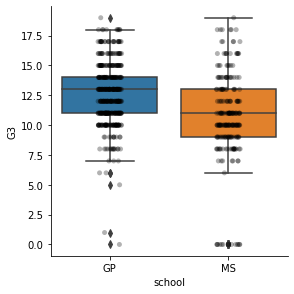

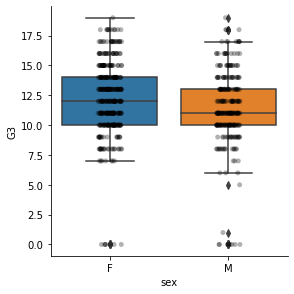

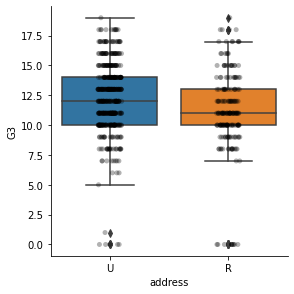

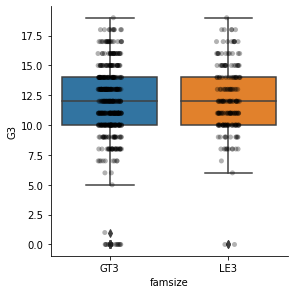

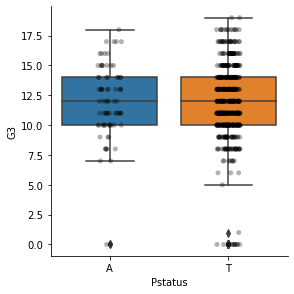

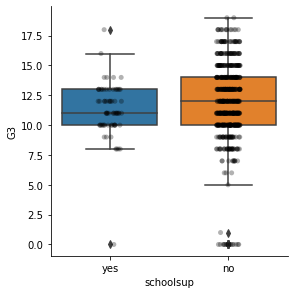

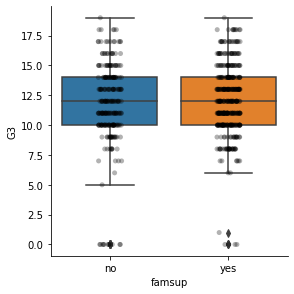

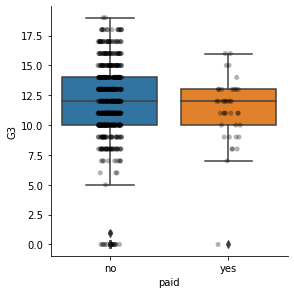

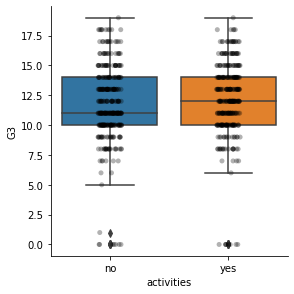

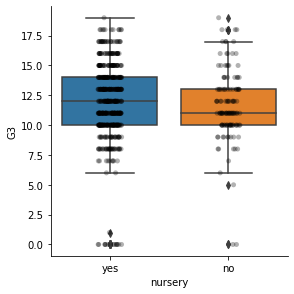

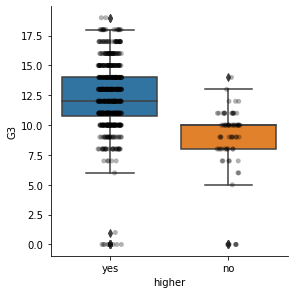

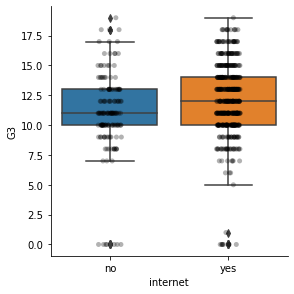

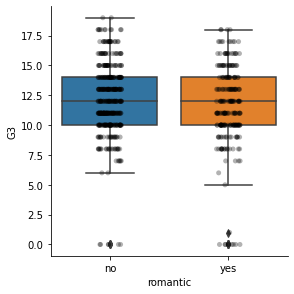

In [9]:
# Visualizamos el impacto de las variables categoricas binarias en frente a G3
for var in categoricalBinary:
    sns.catplot(x=var, y='G3', data=data, kind='box', height=4)
    sns.stripplot(x=var, y='G3', data=data, jitter=0.1, alpha=0.3, color = 'k')
    plt.show()

## 4.2) Separamos y analizamos las categóricas oridinales

In [10]:
categoricalOrdinal = ['Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health']

# Verificamos que no hayan etiquetas
for var in categoricalOrdinal:
    print(xTrain[var].unique())


[4 2 3 1 0]
[2 1 4 3 0]
[2 1 4 3]
[1 3 2 4]
[0 3 1 2]
[5 4 2 3 1]
[5 4 2 1 3]
[5 3 1 4 2]
[3 1 2 5 4]
[4 3 1 2 5]
[5 4 3 2 1]


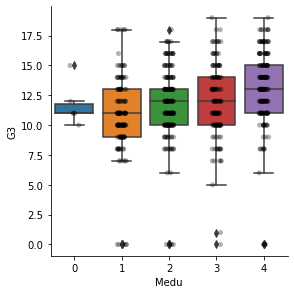

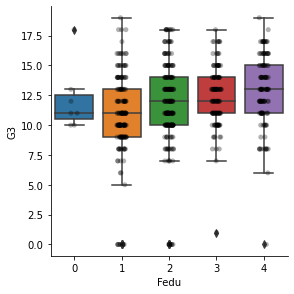

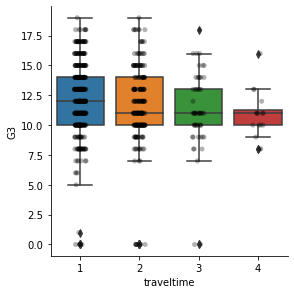

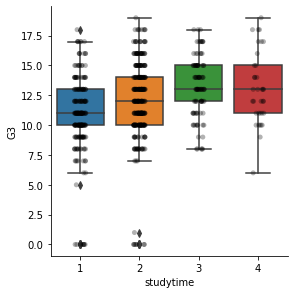

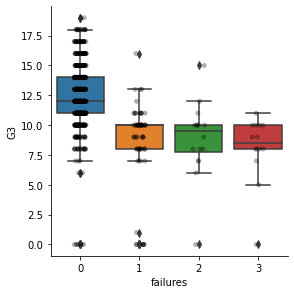

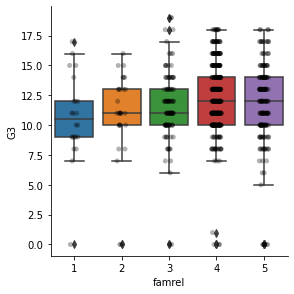

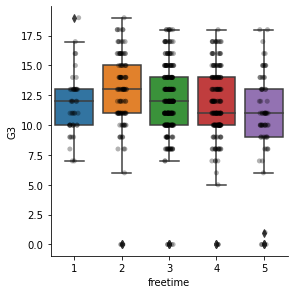

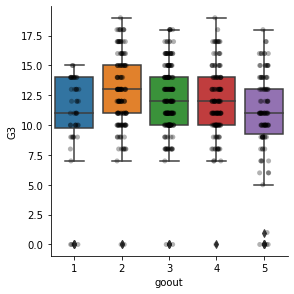

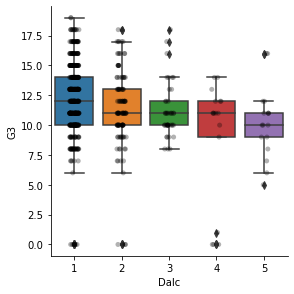

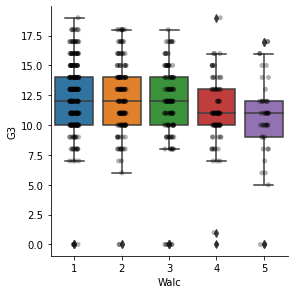

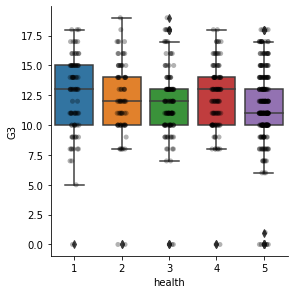

In [11]:
for var in categoricalOrdinal:
    sns.catplot(x=var, y='G3', data=data, kind='box', height=4)
    sns.stripplot(x=var, y='G3', data=data, jitter=0.1, alpha=0.3, color = 'k')
    plt.show()

## 4.3) Tratamos las variables categóricas nominales

In [12]:
# Separamos las variables categorica ordinales
categoricalNominal = [var for var in categoricalVars if var not in categoricalBinary + categoricalOrdinal]
print(categoricalNominal)

['Mjob', 'Fjob', 'reason', 'guardian']


In [13]:
# Analizamos si hay etiquetas con poca frecuencia
rarePerc = 0.2
for var in categoricalNominal:
    temp = data.groupby(var)['G3'].count()/len(data)
    print(temp)
    print()

Mjob
at_home     0.208012
health      0.073960
other       0.397535
services    0.209553
teacher     0.110940
Name: G3, dtype: float64

Fjob
at_home     0.064715
health      0.035439
other       0.565485
services    0.278891
teacher     0.055470
Name: G3, dtype: float64

reason
course        0.439137
home          0.229584
other         0.110940
reputation    0.220339
Name: G3, dtype: float64

guardian
father    0.235747
mother    0.701079
other     0.063174
Name: G3, dtype: float64



La data parece no tener etiquetas raras

In [14]:
# Codificamos las variables nominales
ordinalEncoder = OrdinalEncoder(encoding_method='ordered', variables=categoricalNominal)
ordinalEncoder.fit(xTrain, yTrain)
xTrain = ordinalEncoder.transform(xTrain)
xTest = ordinalEncoder.transform(xTest)
xTrain

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2
52,1,0,15,1,1,0,4,2,4,3,...,1,5,5,5,3,4,5,4,10,9
571,0,0,19,1,0,1,2,1,0,2,...,0,4,4,3,1,3,5,4,8,9
167,1,1,17,1,0,1,4,4,1,4,...,0,4,2,1,1,1,4,0,13,13
592,0,1,17,1,0,1,3,3,2,1,...,1,4,4,3,1,1,4,0,11,12
527,0,0,16,1,1,1,2,2,2,1,...,1,5,1,3,2,2,3,0,10,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
621,0,1,17,0,0,1,1,2,1,1,...,1,3,2,2,1,2,3,0,13,13
128,1,0,16,0,0,1,4,4,3,4,...,1,3,5,5,2,5,4,8,14,14
57,1,0,15,1,0,1,4,4,3,3,...,1,3,2,2,1,1,5,8,15,15
341,1,1,19,1,0,1,4,4,4,2,...,1,2,3,4,2,3,2,2,14,13


# 5) Analizamos las variables numericas

In [15]:
# Separamos las variables numericas
numericalVariables = [var for var in xTrain.columns if var not in categoricalVars]
print(numericalVariables)

['age', 'absences', 'G1', 'G2']


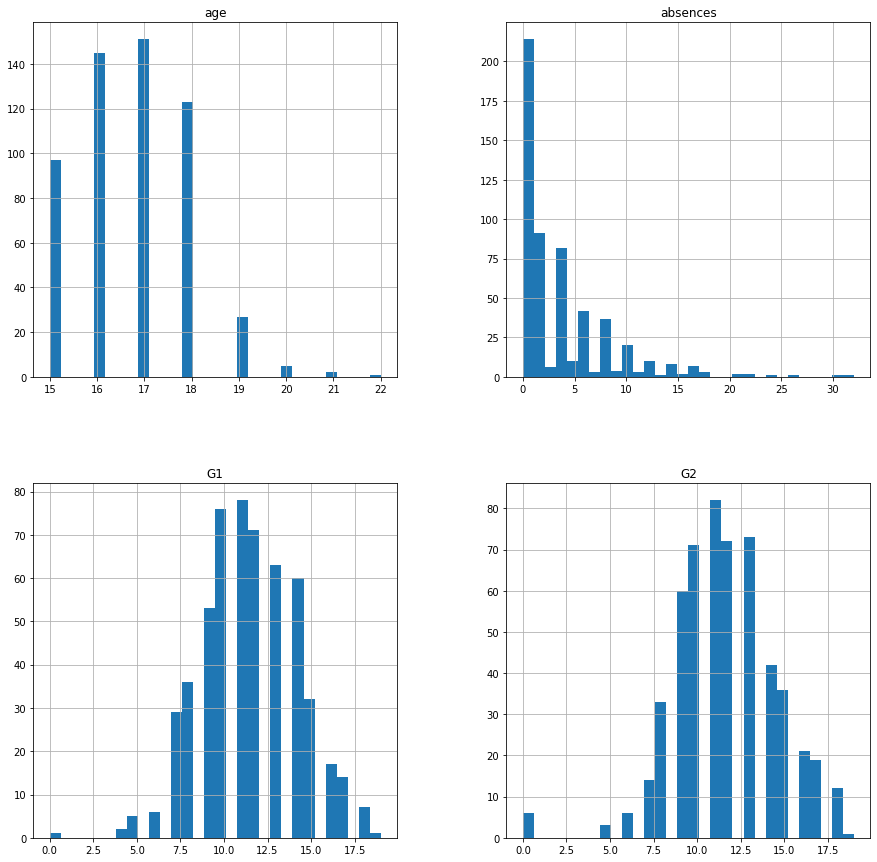

In [16]:
# Analizamos su distribucion
xTrain[numericalVariables].hist(bins=30, figsize=(15, 15))
plt.show()

C:\Users\juan_\anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


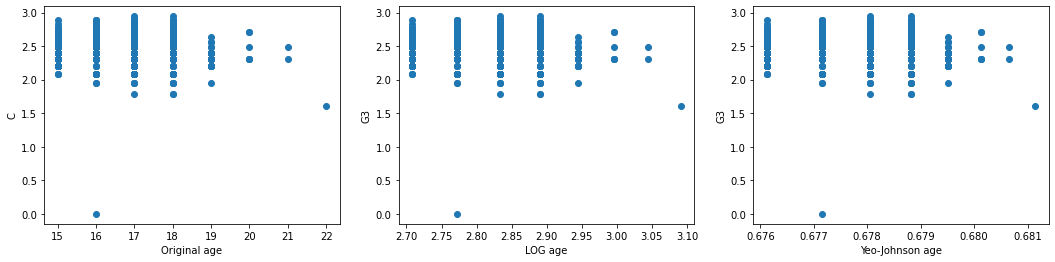

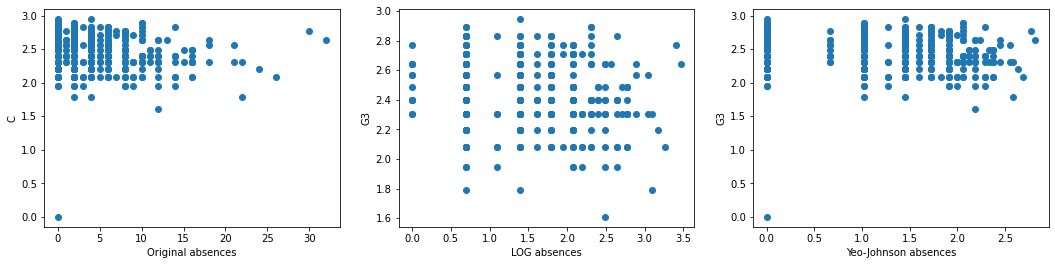

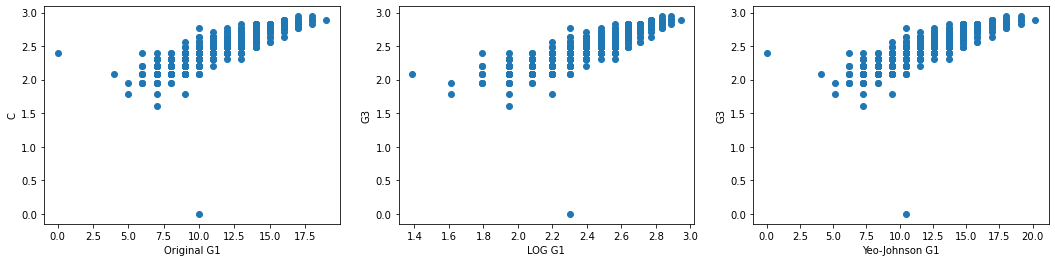

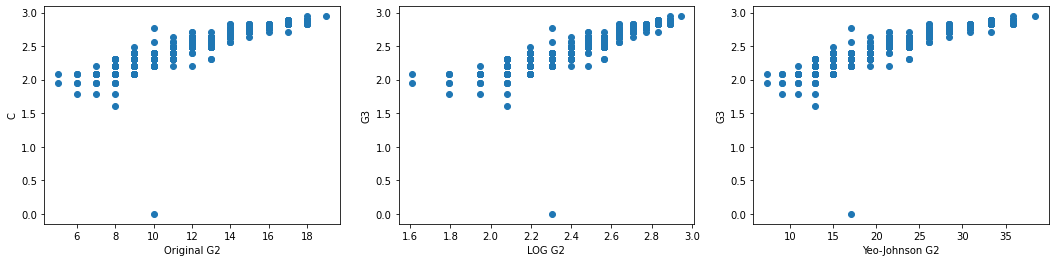

In [17]:
# Analizamos las transformaciones a utilizar
temp_yj = data.copy()
temp_log = data.copy()
for var in numericalVariables:
    temp_yj[var], param = stats.yeojohnson(data[var])
    temp_log[var] = np.log(data[var])
    
for var in numericalVariables:
    plt.figure(figsize=(18, 4))
    
    plt.subplot(1, 3, 1)
    plt.scatter(data[var], np.log(data['G3']))
    plt.ylabel('C')
    plt.xlabel('Original ' + var)
    
    plt.subplot(1, 3, 2)
    plt.scatter(temp_log[var], np.log(data['G3']))
    plt.ylabel('G3')
    plt.xlabel('LOG ' + var)
    
    plt.subplot(1, 3, 3)
    plt.scatter(temp_yj[var], np.log(data['G3']))
    plt.ylabel('G3')
    plt.xlabel('Yeo-Johnson ' + var)
    
    plt.show()

En "Age" no hay mucha diferencia entre la transformacion yeojohnson y la logaritmica y en "Absences" se ve mejor yeojohnson asi que por practisidad, aplicaremos la yeojohnson en las dos

In [18]:
# Aplicamos la tranformacion de yeo-johnson
sesgadas = ['age', 'absences']
for var in sesgadas:
    xTrain[var], param = stats.yeojohnson(xTrain[var])
    xTest[var] = stats.yeojohnson(xTest[var], lmbda=param)

# 6) Feature Scaling

In [19]:
scaler = MinMaxScaler()
scaler.fit(xTrain)
xTrain = pd.DataFrame(scaler.transform(xTrain), columns=xTrain.columns)
xTest = pd.DataFrame(scaler.transform(xTest), columns=xTest.columns)
xTrain.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2
0,1.0,0.0,0.000000,1.0,1.0,0.0,1.00,0.50,1.00,0.75,...,1.0,1.00,1.00,1.0,0.50,0.75,1.00,0.510265,0.526316,0.473684
1,0.0,0.0,0.672600,1.0,0.0,1.0,0.50,0.25,0.00,0.50,...,0.0,0.75,0.75,0.5,0.00,0.50,1.00,0.510265,0.421053,0.473684
2,1.0,1.0,0.380637,1.0,0.0,1.0,1.00,1.00,0.25,1.00,...,0.0,0.75,0.25,0.0,0.00,0.00,0.75,0.000000,0.684211,0.684211
3,0.0,1.0,0.380637,1.0,0.0,1.0,0.75,0.75,0.50,0.25,...,1.0,0.75,0.75,0.5,0.00,0.00,0.75,0.000000,0.578947,0.631579
4,0.0,0.0,0.203614,1.0,1.0,1.0,0.50,0.50,0.50,0.25,...,1.0,1.00,0.00,0.5,0.25,0.25,0.50,0.000000,0.526316,0.473684


# 7) Con Lasso seleccionamos las variables vamos a utilizar y entrenamos el modelo

In [20]:
# Seleccionamos las variables a utilizar
sel_ = SelectFromModel(Lasso(alpha=0.001, random_state=2021))
sel_.fit(xTrain, yTrain)

selectedFeatures = xTrain.columns[(sel_.get_support())]
print('Variables que se van a descartar', xTrain.columns[~sel_.get_support()])

Variables que se van a descartar Index(['internet'], dtype='object')


In [21]:
# Nos quedamos con las variables que nos devuelve lasso
xTrain = xTrain[selectedFeatures]
xTest = xTest[selectedFeatures]

linearModel = Lasso(alpha=0.001, random_state=2022)
linearModel.fit(xTrain, yTrain)

predsTrain = np.around(linearModel.predict(xTrain))
predsTest =  np.around(linearModel.predict(xTest))
predsTest

array([11.,  7., 12.,  8., 10., 13., 11.,  8., 13., 16., 11.,  9., 10.,
       11., 13., 10., 16., 12., 10., 11., 11., 10., 12.,  8., 15.,  1.,
        9.,  9., 10.,  9., 15., 14., 11.,  6., 15., 14., 14., 11., 10.,
       13., 12., 11., 17., 14.,  9.,  9., 15.,  9., 13., 18.,  8.,  6.,
       14., 11., 10., 11., 11.,  9., 12., 11., 11., 13., 13., 11., 15.,
       13., 10.,  8., 11., 17., 11., 16., 11., 12., 13., 11.,  9.,  8.,
       12., 10., 13., 16., 15., 12., 11., 14., 15., 10., 12., 10., 14.,
       12., 11., 15., 18., 13., 10., 12.])

# 8) Analisamos los resultados

In [22]:
# Resultados del Train
print("MSE de entrenamiento: {}".format(mean_squared_error(yTrain, predsTrain)))
print("RMSE de entrenamiento: {}".format(mean_squared_error(yTrain, predsTrain, squared=False)))
print("R2 de entrenamiento: {}".format(r2_score(yTrain, predsTrain)))

MSE de entrenamiento: 1.5081669691470054
RMSE de entrenamiento: 1.228074496578691
R2 de entrenamiento: 0.8552315158796655


In [23]:
# Resultados del Test
print("MSE de entrenamiento: {}".format(mean_squared_error(yTest, predsTest)))
print("RMSE de entrenamiento: {}".format(mean_squared_error(yTest, predsTest, squared=False)))
print("R2 de entrenamiento: {}".format(r2_score(yTest, predsTest)))

MSE de entrenamiento: 1.9489795918367347
RMSE de entrenamiento: 1.3960585918351474
R2 de entrenamiento: 0.8112039054304849


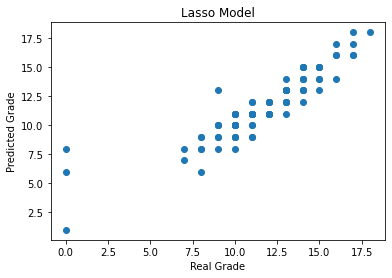

In [24]:
plt.scatter(yTest, predsTest)
plt.xlabel('Real Grade')
plt.ylabel('Predicted Grade')
plt.title('Lasso Model')
plt.show()

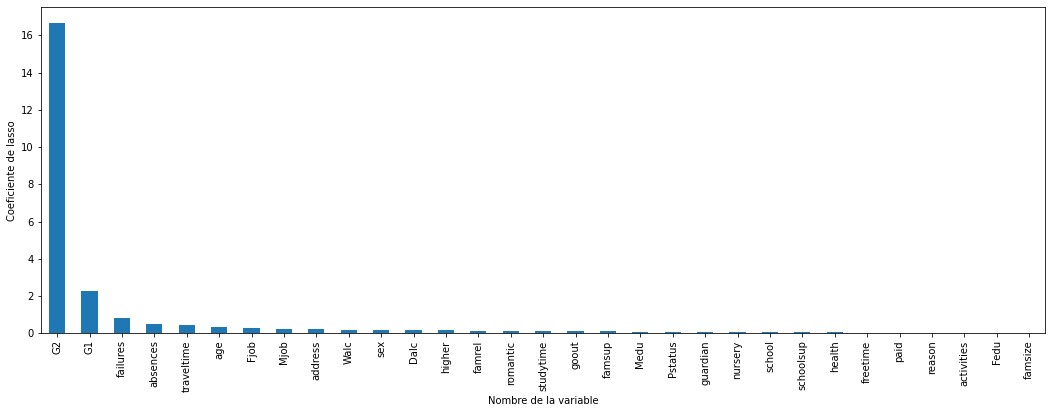

In [25]:
importance = pd.Series(np.abs(linearModel.coef_.ravel()))
importance.index = selectedFeatures
importance.sort_values(inplace=True, ascending=False)

importance.plot.bar(figsize=(18, 6))
plt.ylabel('Coeficiente de lasso')
plt.xlabel('Nombre de la variable')
plt.show()

# 9) Exportamos el modelo

In [26]:
joblib.dump(linearModel, 'preprocess_data/finnalModelLassoRegression.joblib')
joblib.dump(scaler, 'preprocess_data/minmax_scaler.joblib')

pd.Series(selectedFeatures).to_csv('preprocess_data/selected_features.csv', index=False)

xTrain.to_csv('preprocess_data/prep_xTrain.csv', index=False)
xTest.to_csv('preprocess_data/prep_xTest.csv', index=False)

yTrain.to_csv('preprocess_data/prep_yTrain.csv', index=False)
yTest.to_csv('preprocess_data/prep_yTest.csv', index=False)

In [27]:
selectedFeatures

Index(['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc',
       'health', 'absences', 'G1', 'G2'],
      dtype='object')